## Coupled Degradation Mechanisms

See how different degradation mechanisms - SEI Layer, Li-plating, particle cracking and stress driven LAM interact with each other.

In [29]:
import pybamm
import matplotlib.pyplot as plt

* SEI is set to solven diffusion limited, which means that initial SEI layer is already present.

* SEI porosity can change due to particle cracking.

* Li-plating is set to partially reversible so that presence of SEI Layer can interact with irreversible part of Li plating.

* Particle mechanics

In [30]:
model = pybamm.lithium_ion.DFN(
    {
        "SEI": "solvent-diffusion limited",
        "SEI porosity change": "true",
        "lithium plating": "partially reversible",
        "lithium plating porosity change": "true", 
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "SEI on cracks": "true",
        "loss of active material": "stress-driven",
    }
)

In [31]:
my_param = pybamm.ParameterValues("OKane2022")

Particle cracking model needs a large number of mesh points.

In [32]:
my_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator
    "x_p": 5,  # positive electrode
    "r_n": 30,  # negative particle
    "r_p": 30,  # positive particle
}

The experiment is divided into 3 parts:
* 1. Fully discharge the battery from 100% SoC and charge it again to get baseline capacity. Rest the battery at 100% SoC and 0% SoC to reach equillibrium.

* 2. Perform cycles of discharging+charging to degrade the battery via degradation mechanisms.

* 3. Finally discharge the battery to calculate final capacity.

In [33]:
cycle_number = 10
my_exp = pybamm.Experiment(
    [
        "Hold at 4.2 V until C/100",
        "Rest for 4 hours",
        "Discharge at 0.1C until 2.5 V",  # initial capacity check
        "Charge at 0.3C until 4.2 V",
        "Hold at 4.2 V until C/100",
    ]
    + [
        (
            "Discharge at 1C until 2.5 V",  # ageing cycles
            "Charge at 0.3C until 4.2 V",
            "Hold at 4.2 V until C/100",
        )
    ]
    * cycle_number
    + ["Discharge at 0.1C until 2.5 V"],  # final capacity check
)

sim = pybamm.Simulation(model, parameter_values=my_param, experiment=my_exp, var_pts=my_pts)
sol = sim.solve()

Now extract all desired varaiables from solution to plot.

For this we use **sol[varaible_name].entries** to get the data for that variable

In [ ]:
print(model.variables.search("loss"));

Results for 'loss of active material': ['Loss of lithium due to loss of active material in negative electrode [mol]', 'Loss of lithium due to loss of active material in positive electrode [mol]', 'Loss of active material in negative electrode [%]', 'Loss of active material in positive electrode [%]']
None


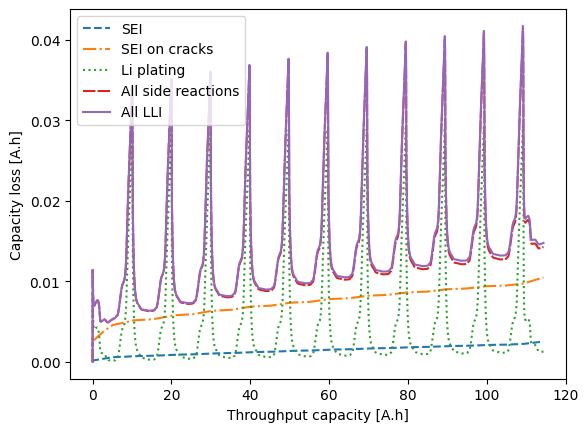

In [ ]:
Qt = sol["Throughput capacity [A.h]"].entries
Q_SEI = sol["Loss of capacity to negative SEI [A.h]"].entries
Q_SEI_cr = sol["Loss of capacity to negative SEI on cracks [A.h]"].entries
Q_plating = sol["Loss of capacity to negative lithium plating [A.h]"].entries
Q_side = sol["Total capacity lost to side reactions [A.h]"].entries
Q_LLI = (sol["Total lithium lost [mol]"].entries * 96485.3 / 3600)  # convert from mol to A.h

plt.figure()
plt.plot(Qt, Q_SEI, linestyle="dashed")
plt.plot(Qt, Q_SEI_cr, label="SEI on cracks", linestyle="dashdot")
plt.plot(Qt, Q_plating, label="Li plating", linestyle="dotted")
plt.plot(Qt, Q_side, label="All side reactions", linestyle=(0, (6, 1)))
plt.plot(Qt, Q_LLI, label="All LLI")
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Capacity loss [A.h]")
plt.legend()
plt.show()

![Alt text](/Users/asthana001/Desktop/PyBaMM_tuts/images/capacity_plot.png)

## Plot Explanation

**Throughput capacity** - the total amount of energy a battery can store and deliver over its entire lifetime.

1. Capacity loss by SEI is very minimal as SEI layer is already grown and does not consume much Li thereafter. If SEI was set to reaction-limited, we would have seen a larger capacity loss.

2. Capacity loss by Li plating increases during charging and decreases during discharging. However, there is still some capacity loss over time as Li plating interacts with SEI layer and not Li is recovered.

3. LLI is caused by - SEI layer, Li plating and SEI on cracks. Their cumulative capacity loss is shown in purple color, majorly dominated by Li plating.